In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#import torch which has many of the functions to build deep learning models and to train them
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import torchvision, which was lots of functions for loading and working with image data
import torchvision
import torchvision.transforms as transforms

#this is a nice progress bar representation that will be good to measure progress during training
import tqdm

#load data
imagenet_means = (0.485, 0.456, 0.406)
imagenet_stds = (0.229, 0.224, 0.225)

transform = transforms.Compose(
    [transforms.ToTensor(),
     #224 x 224
    transforms.Resize((224,224)),
    transforms.Normalize(imagenet_means, imagenet_stds),
    ])

full_data = torchvision.datasets.ImageFolder('trainval', transform = transform)

#separate in val and train
train_portion = 0.8
val_portion = 0.2

all_idxes = np.arange(len(full_data))
all_targets=[data[1] for data in full_data]

train_idx, val_idx = train_test_split(all_idxes, train_size=train_portion, stratify = all_targets, random_state = 0)


train_dataset = torch.utils.data.Subset(full_data, train_idx)
val_dataset = torch.utils.data.Subset(full_data, val_idx)


print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of val dataset: {len(val_dataset)}')

batch_size = 4

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False)

#tranform inputs

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomRotation(degrees=(0, 360)),
     transforms.RandomResizedCrop(size=(224,224), scale=(0.5, 1.0))
    ])

Size of train dataset: 852
Size of val dataset: 213


In [40]:
#load models

torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available

dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dino.eval()
dino.to(device)

torchm=torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

in_features = torchm.fc.in_features
torchm.fc = nn.Linear(torchm.fc.in_features, 10)


for data in trainloader:
    inputs, labels = data

    inputs = inputs.to(device)
    dino_f = dino(inputs)
    torch_f= feature_extractor(inputs)

    print(dino_f.size())
    print(torch_f.size())
    break

Using cache found in /tmp/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([4, 384])
torch.Size([4, 512, 1, 1])


In [22]:
#create non linear network

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64,10)

        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        y = self.relu(self.fc2(x))
        return y

In [43]:
#train 
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available
#any hyperparameters
lr = 0.0005
total_epochs = 50

torchm.to(device)
# Step 2: Define a loss function
criterion = nn.CrossEntropyLoss()
# Step 3: Initialise the SGD optimizer.
optimizer = optim.SGD(torchm.parameters(), lr=lr, momentum=0.9)

#Step 4: For n epochs (e.g. loss converged/stops changing)
total_train_loss = []
total_train_acc = []
total_val_loss = []
total_val_acc = []
best_acc = 0
for epoch in range(total_epochs):    
    #Step 4A: Put the model in "train" mode
    torchm.train() 

    #Step 4B: Training loop: For all batches in the training dataset
    train_loss = []
    correct = 0
    total = 0
    for i, data in  tqdm.tqdm(enumerate(trainloader, 0), total = len(trainloader), desc = f'Epoch {epoch+1} - training phase'):
        inputs, labels = data
        inputs = train_transform(inputs)
        inputs=inputs.to(device)
        
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = torchm(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        train_loss += [loss.cpu().item()]
        
        predicted = torch.argmax(outputs, axis = -1)
        
        correct += torch.sum(predicted == labels).cpu().item()
        total += len(labels)

    mean_train_loss = np.mean(train_loss)
    train_accuracy = correct/total

    total_train_loss += [mean_train_loss]
    total_train_acc += [train_accuracy]
    
    #Step 4C: Put the model in "eval" mode
    torchm.eval()

    #Step 4D: Validation loop: For all batches in the validation dataset
    val_loss=[]
    correct=0
    total=0
    for i,data in tqdm.tqdm(enumerate(valloader,0), total=len(valloader), desc = f'Epoch {epoch+1} - validation phase'):
        inputs, labels= data
        inputs=inputs.to(device)
        labels =labels.to(device)
    
        outputs=torchm(inputs)
    
        loss=criterion(outputs, labels)
        
        predicted =torch.argmax(outputs, axis=-1)
    
        correct+= torch.sum(predicted == labels).cpu().item()
        total+=labels.shape[0]

        val_loss+=[loss.cpu().item()]

    mean_val_loss = np.mean(val_loss)
    val_accuracy = correct/total

    total_val_loss += [mean_val_loss]
    total_val_acc += [val_accuracy]

Epoch 50 - validation phase: 100%|██████████| 54/54 [00:01<00:00, 34.81it/s]


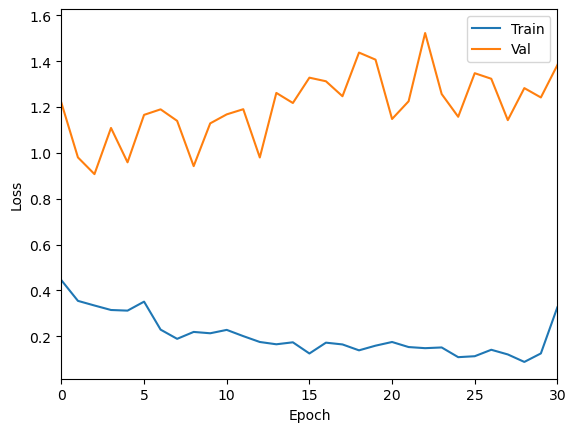

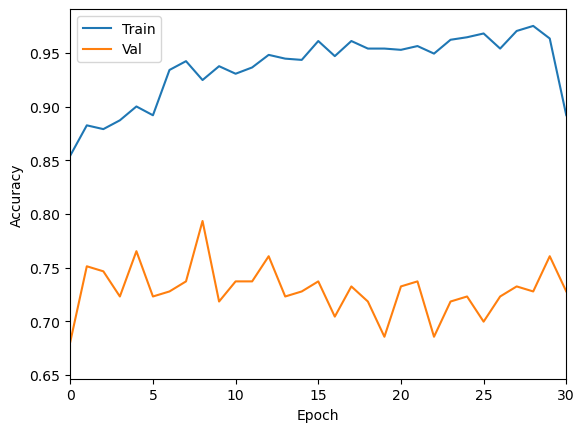

0.9753521126760564
0.7934272300469484


In [48]:
plt.plot(total_train_loss, label = 'Train')
plt.plot(total_val_loss, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.xlim([0, 30])
plt.ylabel('Loss')
plt.show()

plt.plot(total_train_acc, label = 'Train')
plt.plot(total_val_acc, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.xlim([0, 30])
plt.ylabel('Accuracy')
plt.show()

print(max(total_train_acc))
print(max(total_val_acc))